## GRU

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [340]:
df = pd.read_csv("./wfp_food_prices_vnm.csv", 
                 parse_dates=['date'], index_col='date')
df[df.index.year == 2019]

,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
date,,,,,,,,,,,,,
2019-01-15,An Giang,Chau Phu,An Giang,10.522,105.126,cereals and tubers,Rice,KG,actual,Wholesale,VND,8385.0,0.3615
2019-03-15,An Giang,Chau Phu,An Giang,10.522,105.126,cereals and tubers,Rice,KG,actual,Wholesale,VND,8320.0,0.3587
2019-04-15,An Giang,Chau Phu,An Giang,10.522,105.126,cereals and tubers,Rice,KG,actual,Wholesale,VND,8320.0,0.3644
2019-02-12,An Giang,Chau Phu,An Giang,10.678,105.500,cereals and tubers,Rice,KG,forecast,Wholesale,VND,4600.0,NaN
2019-08-03,An Giang,Chau Phu,An Giang,10.678,105.500,cereals and tubers,Rice,KG,forecast,Wholesale,VND,4750.0,NaN
2019-01-04,An Giang,Chau Phu,An Giang,10.678,105.500,cereals and tubers,Rice,KG,forecast,Wholesale,VND,4800.0,NaN
2019-02-05,An Giang,Chau Phu,An Giang,10.678,105.500,cereals and tubers,Rice,KG,forecast,Wholesale,VND,4850.0,NaN
2019-05-05,An Giang,Chau Phu,An Giang,10.678,105.500,cereals and tubers,Rice,KG,forecast,Wholesale,VND,4800.0,NaN
2019-06-14,An Giang,Chau Phu,An Giang,10.678,105.500,cereals and tubers,Rice,KG,forecast,Wholesale,VND,4050.0,NaN


In [341]:
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Price', {'fontsize': 12})

In [342]:
df['price'] = df.groupby(df.index)['price'].transform('mean')
df = df.sort_index()

In [343]:
df = df[df['price'] != 0]
df = df[df['admin1'] == 'An Giang']
df = df.drop_duplicates()

In [344]:
df = pd.read_csv('./data.csv',  parse_dates=['date'], index_col='date')

,price
date,
2008-01-15,5331.605
2008-02-15,5787.000
2008-03-15,6549.875
2008-04-15,7222.500
2008-05-15,8588.890


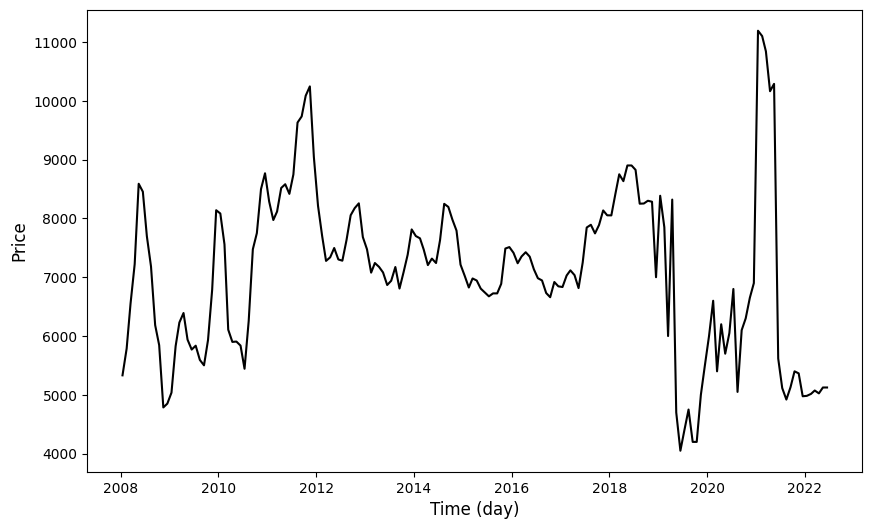

In [345]:
dataset = df.copy()
timeseries(df.index, dataset['price'], 'Time (day)')

(174, 1)
(753, 1)


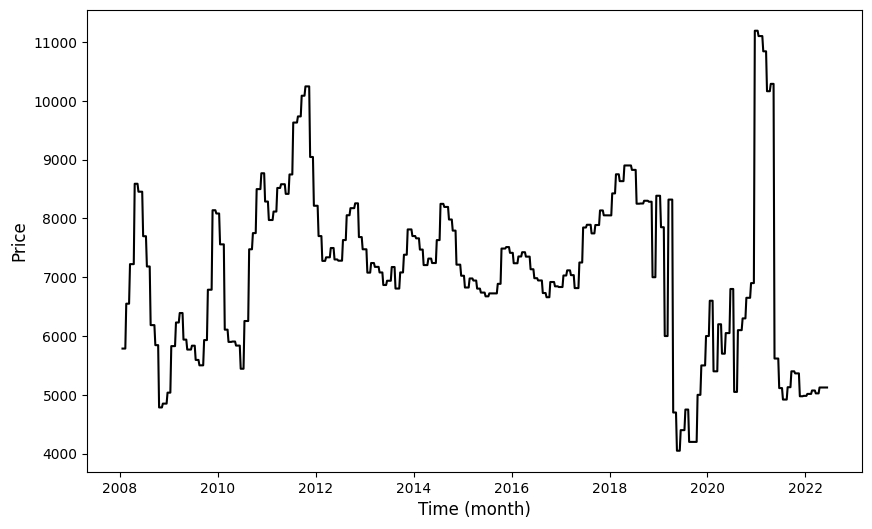

In [346]:
dataset = df.copy()
print(dataset.shape)
dataset_by_month = dataset.resample('W').bfill()
print(dataset_by_month.shape)

timeseries(dataset_by_month.index, dataset_by_month['price'], 'Time (month)')

In [347]:
df.index

DatetimeIndex(['2008-01-15', '2008-02-15', '2008-03-15', '2008-04-15',
               '2008-05-15', '2008-06-15', '2008-07-15', '2008-08-15',
               '2008-09-15', '2008-10-15',
               ...
               '2021-09-15', '2021-10-15', '2021-11-15', '2021-12-15',
               '2022-01-15', '2022-02-15', '2022-03-15', '2022-04-15',
               '2022-05-15', '2022-06-15'],
              dtype='datetime64[ns]', name='date', length=174, freq=None)

In [348]:
# Check for missing values
df = df.loc[:,['price']]
df.head()

,price
date,
2008-01-15,5331.605
2008-02-15,5787.000
2008-03-15,6549.875
2008-04-15,7222.500
2008-05-15,8588.890


In [349]:
print('Total num of missing values:') 
print(df.price.isna().sum())
df.price.isna()

Total num of missing values:
0


date
2008-01-15    False
2008-02-15    False
2008-03-15    False
2008-04-15    False
2008-05-15    False
              ...  
2022-02-15    False
2022-03-15    False
2022-04-15    False
2022-05-15    False
2022-06-15    False
Name: price, Length: 174, dtype: bool

In [350]:
df[df.index.duplicated()]

,price
date,


In [351]:
df.dropna(subset=['price'], inplace=True)

In [352]:
df = df.groupby('date', as_index=True).mean()
df.head()

,price
date,
2008-01-15,5331.605
2008-02-15,5787.000
2008-03-15,6549.875
2008-04-15,7222.500
2008-05-15,8588.890


In [353]:
df.shape

(174, 1)

In [354]:
# dataset = df.resample('D').ffill()
# dataset.shape

In [355]:
# timeseries(dataset.index, dataset['price'], 'Time (day)')

In [356]:
dataset = df.copy()
dataset = dataset.resample('W').ffill()
# Split train data and test data
train_size = int(len(dataset)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = dataset.iloc[:train_size]
test_data = dataset.iloc[train_size:]

In [357]:
print(test_data.isna().sum())

price    0
dtype: int64


In [358]:
print(train_data.shape)
print(test_data.shape)

train_size

(602, 1)
(151, 1)


602

In [359]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [379]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)
# Gia 12 thang
look_back = 48
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (554, 48, 1)
y_train.shape:  (554, 1)
X_test.shape:  (103, 48, 1)
y_test.shape:  (103, 1)


In [361]:
y_train[3]

array([0.51215242])

In [380]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                        
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
   
    return model
model_gru = create_gru(64)

In [381]:
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, return_sequences=True, 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units, return_sequences=True))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
   
model_lstm = create_lstm(64)

In [382]:
def fit_model(model):
    history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, shuffle = False)
    return history

In [383]:
history_gru = fit_model(model_gru)

Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.0449
Epoch 2/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0181
Epoch 3/100
18/18 [==============================] - 1s 48ms/step - loss: 0.0089
Epoch 4/100
18/18 [==============================] - 1s 34ms/step - loss: 0.0083
Epoch 5/100
18/18 [==============================] - 1s 30ms/step - loss: 0.0073
Epoch 6/100
18/18 [==============================] - 1s 32ms/step - loss: 0.0072
Epoch 7/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0075
Epoch 8/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0071
Epoch 9/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0065
Epoch 10/100
18/18 [==============================] - 0s 27ms/step - loss: 0.0065
Epoch 11/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0064
Epoch 12/100
18/18 [==============================] - 1s 29ms/step - loss: 0.0078
Epoch 13/100
18/18 [=====

In [384]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
18/18 [==============================] - 11s 49ms/step - loss: 0.0648
Epoch 2/100
18/18 [==============================] - 1s 45ms/step - loss: 0.0219
Epoch 3/100
18/18 [==============================] - 1s 51ms/step - loss: 0.0253
Epoch 4/100
18/18 [==============================] - 1s 43ms/step - loss: 0.0255
Epoch 5/100
18/18 [==============================] - 1s 53ms/step - loss: 0.0231
Epoch 6/100
18/18 [==============================] - 1s 59ms/step - loss: 0.0177
Epoch 7/100
18/18 [==============================] - 1s 59ms/step - loss: 0.0172
Epoch 8/100
18/18 [==============================] - 1s 45ms/step - loss: 0.0182
Epoch 9/100
18/18 [==============================] - 1s 60ms/step - loss: 0.0180
Epoch 10/100
18/18 [==============================] - 2s 82ms/step - loss: 0.0183
Epoch 11/100
18/18 [==============================] - 1s 52ms/step - loss: 0.0148
Epoch 12/100
18/18 [==============================] - 1s 39ms/step - loss: 0.0131
Epoch 13/100
18/18 [====

In [399]:
model_gru.save("model_gru.keras")
model_lstm.save("model_lstm.keras")

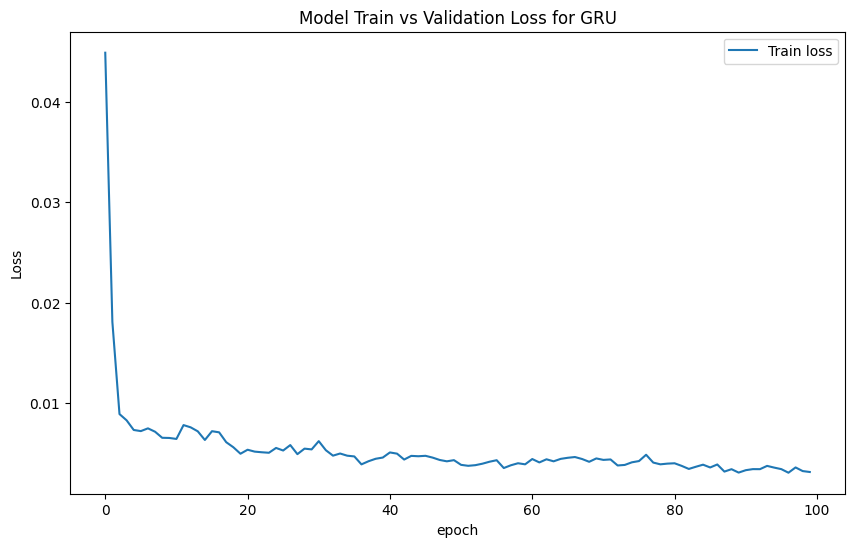

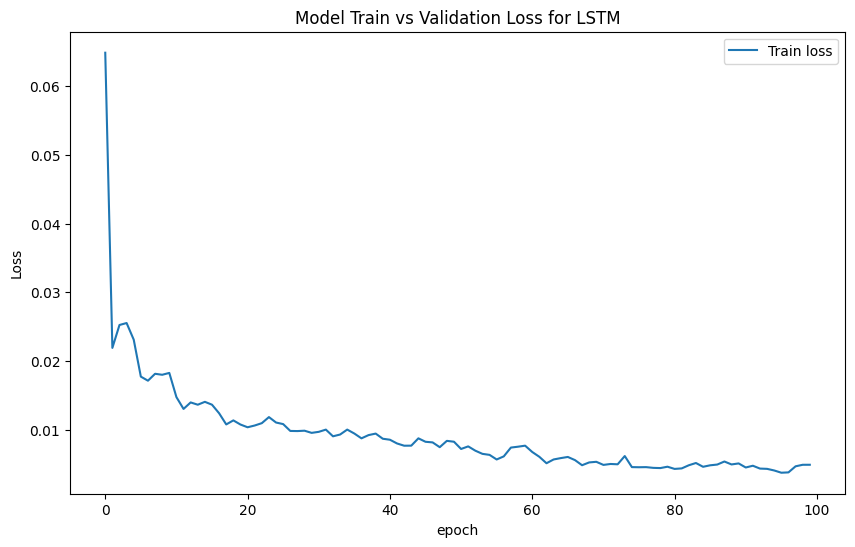

In [385]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_lstm, 'LSTM')

In [386]:
# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def prediction_train(model):
    prediction = model.predict(X_train)
    prediction = scaler.inverse_transform(prediction)
    return prediction


prediction_gru = prediction(model_gru)
prediction_gru_train = prediction_train(model_gru)

prediction_lstm = prediction(model_lstm)
prediction_lstm_train = prediction_train(model_lstm)

18/18 [==============================] - 0s 15ms/step


GRU:
Mean Absolute Error: 220.8578
Root Mean Square Error: 679.8595
0.9017822769860021

GRU:
Mean Absolute Error: 331.5117
Root Mean Square Error: 729.4446
0.8910812615738258



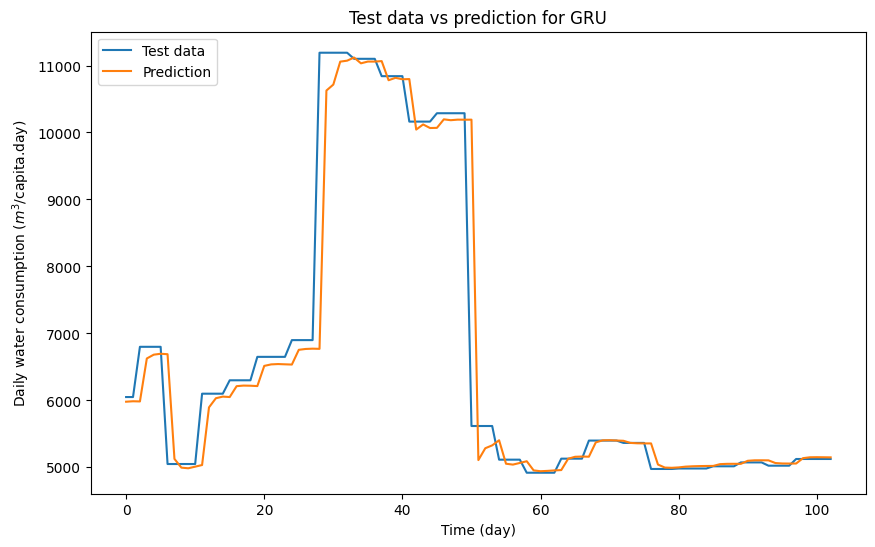

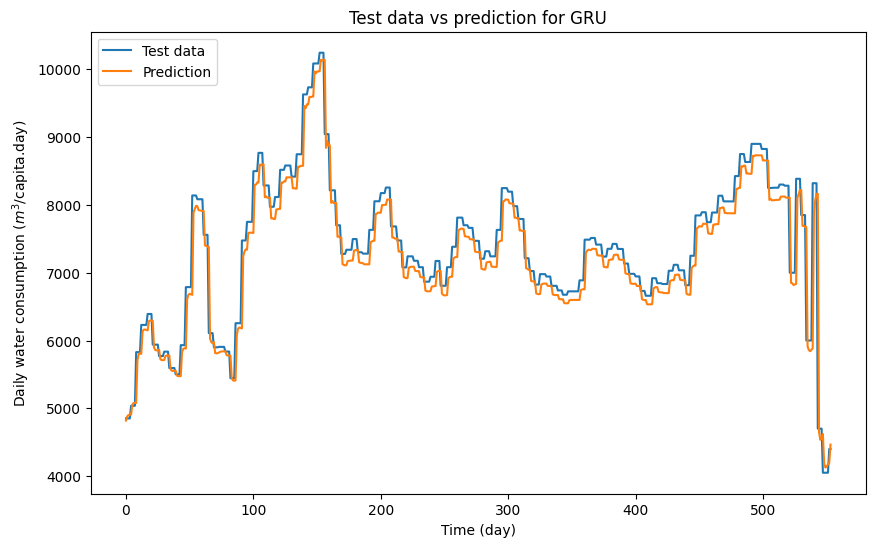

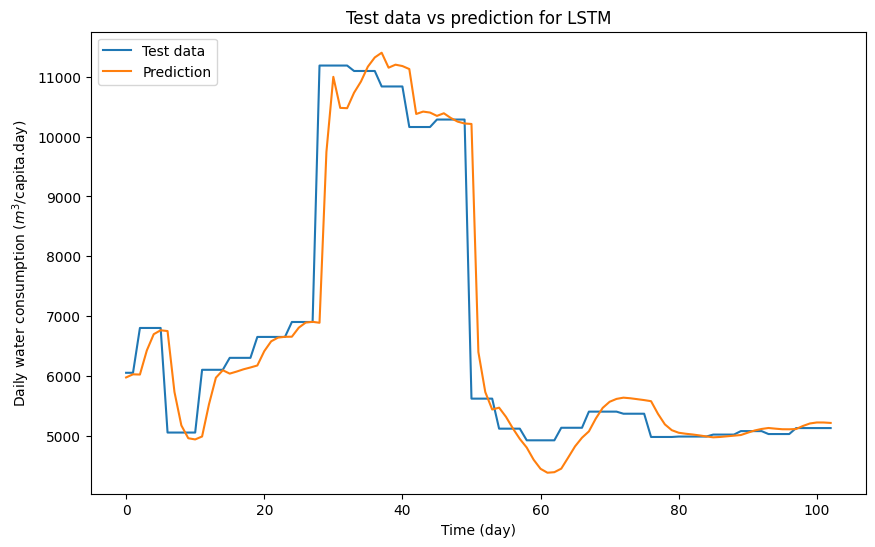

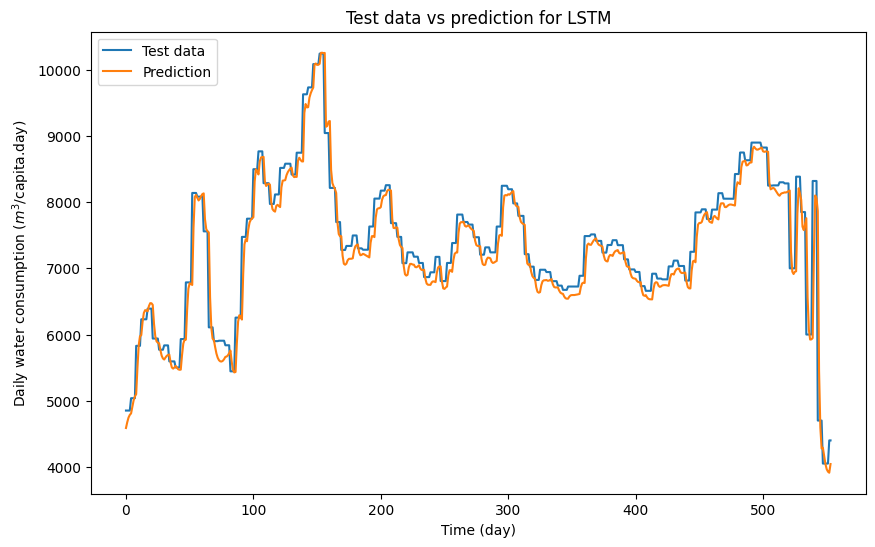

In [387]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
       
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_gru_train, 'GRU', y_train)


plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_lstm_train, 'LSTM', y_train)



from sklearn.metrics import r2_score 
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print(r2_score(predictions, actual))
    print('')

evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_lstm, y_test, 'GRU')

In [388]:
def predict(forecast_num, model,data,look_back):
  prediction_list = data[-look_back:]

  for _ in range(forecast_num):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, 1))
      out = model.predict(x)[0][0]
      prediction_list = np.append(prediction_list, out)
  prediction_list = prediction_list[look_back-1:]

  return prediction_list

def predict_dates(forecast_num, data):
    last_date = data.index[-1]
    prediction_dates = pd.date_range(last_date, periods=forecast_num+1).tolist()
    return prediction_dates

In [394]:
forecast_num = 12 #number of day to predict after the last date in data
forecast=predict(forecast_num, model=model_lstm,data=X_test[-1:],look_back=48)
forecast_date=predict_dates(forecast_num, df)

1/1 [==============================] - 0s 25ms/step


In [395]:
close_data = X_test[-1:].reshape((-1))
print(close_data.shape)
print(close_data[-48:])
X_train.shape

(48,)
[0.17192824 0.17192824 0.17192824 0.17192824 0.14044842 0.14044842
 0.14044842 0.14044842 0.14044842 0.17434976 0.17434976 0.17434976
 0.17434976 0.2179372  0.2179372  0.2179372  0.2179372  0.2179372
 0.21228698 0.21228698 0.21228698 0.21228698 0.14948878 0.14948878
 0.14948878 0.14948878 0.15061882 0.15061882 0.15061882 0.15061882
 0.15061882 0.15594617 0.15594617 0.15594617 0.15594617 0.1653094
 0.1653094  0.1653094  0.1653094  0.15739909 0.15739909 0.15739909
 0.15739909 0.17354259 0.17354259 0.17354259 0.17354259 0.17354259]


(554, 48, 1)

Text(0, 0.5, 'Daily water consumption ($m^3$/capita.day)')

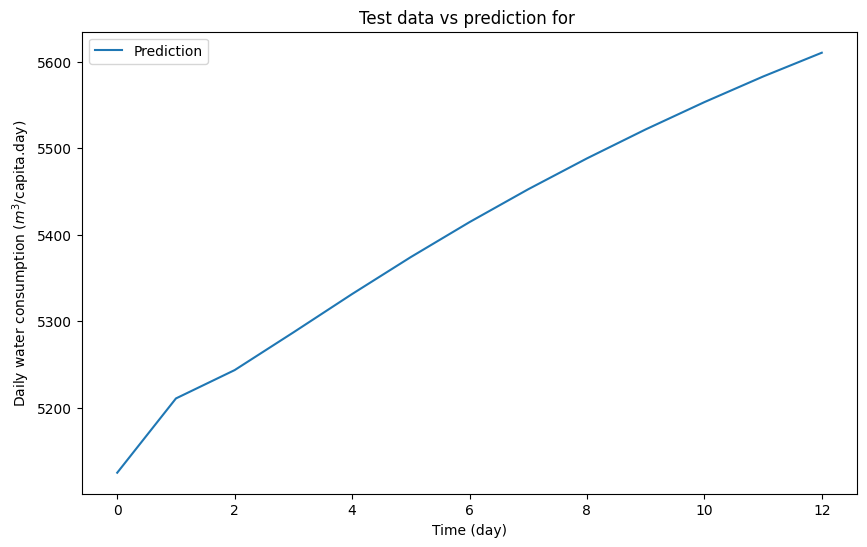

In [396]:
plt.figure(figsize=(10, 6))
    
f =  scaler.inverse_transform(forecast.reshape(-1, 1))
plt.plot(np.array(f),label='Prediction')

plt.title('Test data vs prediction for ')
plt.legend(loc='upper left')
plt.xlabel('Time (day)')
plt.ylabel('Daily water consumption ($m^3$/capita.day)')

In [397]:
forecast_num = 12 #number of day to predict after the last date in data
forecast=predict(forecast_num, model=model_gru,data=X_test[-1:],look_back=48)
forecast_date=predict_dates(forecast_num, df)

1/1 [==============================] - 0s 31ms/step


Text(0, 0.5, 'Daily water consumption ($m^3$/capita.day)')

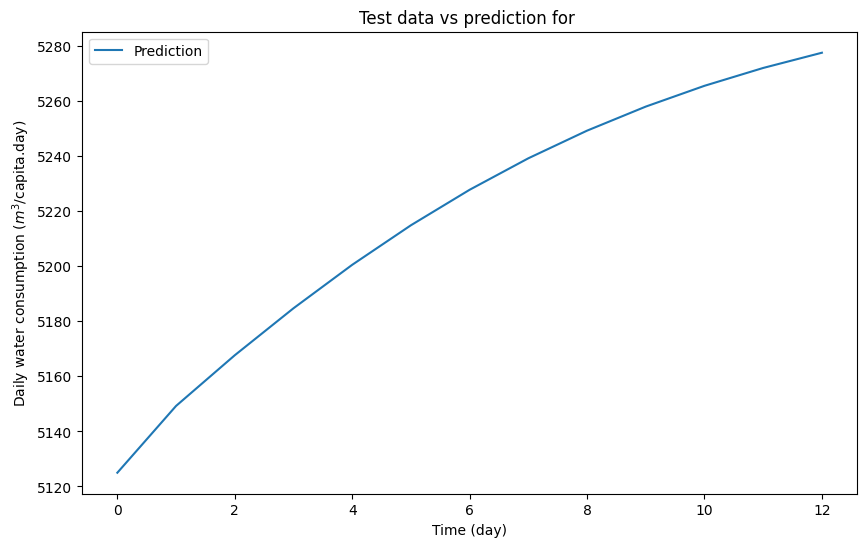

In [398]:
plt.figure(figsize=(10, 6))
    
f =  scaler.inverse_transform(forecast.reshape(-1, 1))
plt.plot(np.array(f),label='Prediction')

plt.title('Test data vs prediction for ')
plt.legend(loc='upper left')
plt.xlabel('Time (day)')
plt.ylabel('Daily water consumption ($m^3$/capita.day)')

### Học có giám sát

In [ ]:
df.head()

,price
date,
2008-01-15,5331.605
2008-02-15,5787.000
2008-03-15,6549.875
2008-04-15,7222.500
2008-05-15,8588.890


In [ ]:
train_size = 0.8
df_gasolinePrices = df.copy()
split_index = int(len(df_gasolinePrices) * train_size)
train, test = df_gasolinePrices[:split_index], df_gasolinePrices[split_index:]
print("train:", len(train))
print("test:", len(test))

train: 142
test: 36


<Figure size 1500x800 with 0 Axes>

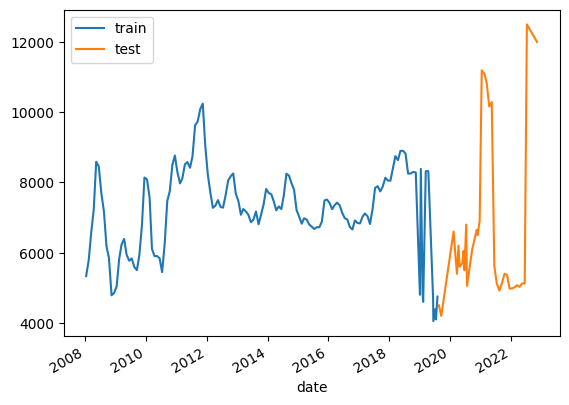

In [ ]:
plt.figure(figsize=(15,8))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [ ]:
scaler = MinMaxScaler()
train['price'] = scaler.fit_transform(train)
test['price'] = scaler.fit_transform(test)

In [ ]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [ ]:
timesteps=5

In [ ]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(138, 5)

In [ ]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(32, 5)

In [ ]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(138, 4) (138, 1)
(32, 4) (32, 1)


# SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

In [ ]:
model = SVR(kernel='rbf',gamma=0.05, C=100, epsilon = 0.05)
model.fit(x_train, y_train[:,0])

SVR(C=100, epsilon=0.05, gamma=0.05)

In [ ]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(138, 1) (32, 1)


In [ ]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

138 32


In [ ]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

138 32


In [ ]:
from sklearn.metrics import mean_squared_error
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'RMSE on training set: {rmse_train}')
print(f'RMSE on testing set: {rmse_test}')

RMSE on training set: 997.4951309057946
RMSE on testing set: 1763.0631632524853


In [ ]:
from xgboost import XGBRegressor

import xgboost as xgb

# Chuẩn bị dữ liệu cho XGBoost
xgb_train = xgb.DMatrix(x_train, label=y_train)
xgb_test = xgb.DMatrix(x_test, label=y_test)

In [ ]:
# Thiết lập các tham số cho mô hình XGBoost
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'n_estimators': 100
}

# Xây dựng mô hình XGBoost
model_xgb = XGBRegressor(**params)

# Huấn luyện mô hình
model_xgb.fit(x_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# Dự đoán trên tập huấn luyện và tập kiểm thử
y_train_pred_xgb = model_xgb.predict(x_train)
y_test_pred_xgb = model_xgb.predict(x_test)

# Tính toán RMSE
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
print(f'RMSE on training set (XGBoost): {rmse_train_xgb}')
print(f'RMSE on testing set (XGBoost): {rmse_test_xgb}')

RMSE on training set (XGBoost): 185.84123411128104
RMSE on testing set (XGBoost): 2648.400776517889


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Thiết lập các tham số cho mô hình Random Forest
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'random_state': 42
}

# Xây dựng mô hình Random Forest
model_rf = RandomForestRegressor(**rf_params)

# Huấn luyện mô hình
model_rf.fit(x_train, y_train.ravel())

RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
# Dự đoán trên tập huấn luyện và tập kiểm thử
y_train_pred_rf = model_rf.predict(x_train)
y_test_pred_rf = model_rf.predict(x_test)

# Tính toán RMSE
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(f'RMSE on training set (Random Forest): {rmse_train_rf}')
print(f'RMSE on testing set (Random Forest): {rmse_test_rf}')


RMSE on training set (Random Forest): 440.2959005496452
RMSE on testing set (Random Forest): 1990.5567369448347


ValueError: x and y must have same first dimension, but have shapes (100,) and (32,)

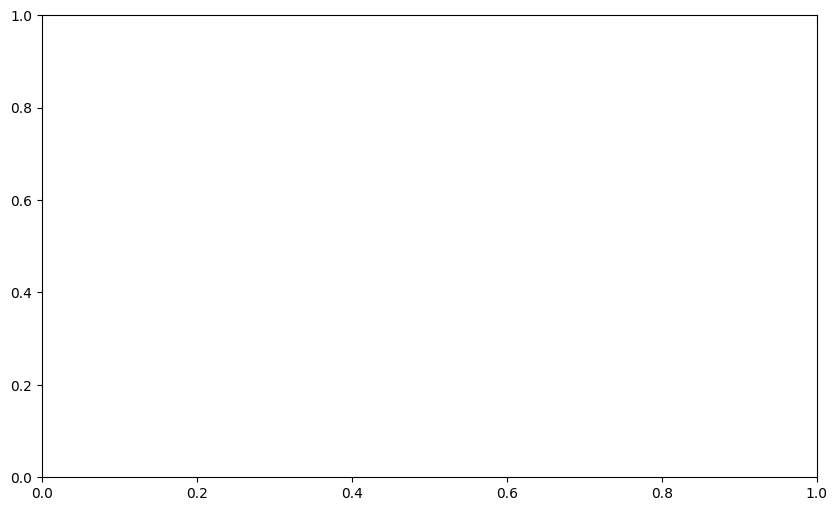

In [ ]:
plot_future(model_rf, 'GRU', y_test_pred_rf)